In [23]:
#!pip install cvxpy

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from itertools import product
import cvxpy as cp # for optimization

In [87]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', '{:.3f}'.format)

### Optimized Portfolio of Sector Indexes

In [4]:
# list of index tickers
symbols = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']

In [5]:
# retrieving data for each sector index
# from 2010 - 2024
# get last month (currently the last month is September) of each year
data = [
    pd.DataFrame(yf.Ticker(symbol).history(start = '2010-01-01', end = '2024-09-18', interval = '3mo'))
    .reset_index()[::-4].sort_values(by = 'Date')
    for symbol in symbols
]

# clean up index of each df - problem is that a couple sector indexes (XLC and XLRE) haven't been around since 2010 like all the other indexes so their
# data doesn't have that index, and then there's a whole mismatching thing and whatnot - this solves that
cleaned_data = [
   df.set_index(np.arange(15 - df.shape[0], 15, 1)) for df in data 
]

In [6]:
# year-to-year return series for each sector index
returns = [
    df['Close'].pct_change()
    for df in cleaned_data
]

# make return series into a dataframe to be able to run .corr() in a later step
df_returns = pd.DataFrame(returns).loc[:, np.arange(0, 15, 1)].assign(symbol = symbols).set_index('symbol').T

In [7]:
# calculate expected/mean returns
means = [
    return_.mean() # get mean return
    for return_ in returns
]

# calculate standard deviations of returns
stds = [
    return_.std() # get std dev of returns
    for return_ in returns
]

In [8]:
# make a dataframe for the important data (expected returns, standard deviations, correlations, covariances)
df = pd.DataFrame()

df['symbol'] = symbols
df['exp_return'] = means
df['std_dev'] = stds

# set index to ticker symbol
df = df.set_index('symbol')

In [9]:
# calculate correlation between each sector indexes' returns
df_corr = df_returns.corr()
# rename columns to include '_corr'
df_corr = df_corr.rename(columns = {col: col + '_corr' for col in df_corr.columns})

df = pd.concat([df, df_corr], axis = 1)

In [10]:
# each possible 2-unit combination of ticker symbols (self-pairing included) - these combinations will be used to calculate covariances based on
# standard deviations and correlations
combs = [i for i in product(symbols, repeat = 2)]

# create covariances dataframe to concatenate to main df
df_covariances = pd.DataFrame()
for symbol in symbols:
    covariances = []
    for comb in combs:
        if comb[0] == symbol:
            std1 = df.loc[comb[0]]['std_dev']
            std2 = df.loc[comb[1]]['std_dev']
            corr = df.loc[comb[0], comb[1] + '_corr']
            cov = std1 * std2 * corr
            covariances.append(cov)
    df_covariances[symbol] = covariances

# rename columns to include '_cov'
df_covariances = df_covariances.T.rename(columns = {i: symbol + '_cov' for i, symbol in zip(np.arange(0, 11, 1), symbols)})

# concat covariances to main df - this completes the main df
df = pd.concat([df, df_covariances], axis = 1)

In [11]:
df

,exp_return,std_dev,XLC_corr,XLY_corr,XLP_corr,XLE_corr,XLF_corr,XLV_corr,XLI_corr,XLB_corr,XLRE_corr,XLK_corr,XLU_corr,XLC_cov,XLY_cov,XLP_cov,XLE_cov,XLF_cov,XLV_cov,XLI_cov,XLB_cov,XLRE_cov,XLK_cov,XLU_cov
XLC,0.156640,0.240789,1.000000,0.868855,0.547662,-0.338117,0.417505,0.547360,0.715103,0.797418,0.451774,0.909214,0.056807,0.057979,0.030030,0.010079,-0.025850,0.023151,0.014826,0.026597,0.028636,0.020785,0.039992,0.001670
XLY,0.158590,0.143539,0.868855,1.000000,0.416543,-0.048657,0.579632,0.798765,0.685508,0.570319,0.427174,0.662467,-0.040680,0.030030,0.020603,0.004570,-0.002218,0.019160,0.012897,0.015199,0.012209,0.011716,0.017370,-0.000713
XLP,0.113155,0.076431,0.547662,0.416543,1.000000,-0.054533,0.450994,0.463533,0.521616,0.529996,0.856537,0.303534,0.704565,0.010079,0.004570,0.005842,-0.001323,0.007938,0.003985,0.006158,0.006041,0.012509,0.004238,0.006573
XLE,0.112495,0.317508,-0.338117,-0.048657,-0.054533,1.000000,0.469317,0.158542,0.362720,0.345269,0.134502,-0.080998,-0.037486,-0.025850,-0.002218,-0.001323,0.100812,0.034316,0.005663,0.017789,0.016350,0.008160,-0.004698,-0.001453
XLF,0.144292,0.230289,0.417505,0.579632,0.450994,0.469317,1.000000,0.654091,0.882938,0.767206,0.740432,0.430823,0.355025,0.023151,0.019160,0.007938,0.034316,0.053033,0.016944,0.031408,0.026350,0.032580,0.018124,0.009979
XLV,0.147797,0.112490,0.547360,0.798765,0.463533,0.158542,0.654091,1.000000,0.731291,0.720995,0.357826,0.588622,0.057887,0.014826,0.012897,0.003985,0.005663,0.016944,0.012654,0.012707,0.012096,0.007691,0.012095,0.000795
XLI,0.140790,0.154466,0.715103,0.685508,0.521616,0.362720,0.882938,0.731291,1.000000,0.894366,0.625629,0.619133,0.257068,0.026597,0.015199,0.006158,0.017789,0.031408,0.012707,0.023860,0.020604,0.018465,0.017470,0.004847
XLB,0.112177,0.149141,0.797418,0.570319,0.529996,0.345269,0.767206,0.720995,0.894366,1.000000,0.560349,0.727693,0.209039,0.028636,0.012209,0.006041,0.016350,0.026350,0.012096,0.020604,0.022243,0.015968,0.019825,0.003805
XLRE,0.090321,0.191071,0.451774,0.427174,0.856537,0.134502,0.740432,0.357826,0.625629,0.560349,1.000000,0.264969,0.779475,0.020785,0.011716,0.012509,0.008160,0.032580,0.007691,0.018465,0.015968,0.036508,0.009248,0.018178
XLK,0.206736,0.182672,0.909214,0.662467,0.303534,-0.080998,0.430823,0.588622,0.619133,0.727693,0.264969,1.000000,-0.043610,0.039992,0.017370,0.004238,-0.004698,0.018124,0.012095,0.017470,0.019825,0.009248,0.033369,-0.000972


In [83]:
# CVXPY optimization --- superior to dirichlet sampling, and it allows me to set a target return (useful for scenario analysis) among other constraints

# output dataframe
df_output = pd.DataFrame()

# array of target return scenarios
target_return_scenarios = np.arange(0.05, 0.155, 0.005)

# apparently I have to perform "eigen decomposition" to turn any negative covariances positive
# this is to make sure my covariance matrix is "positive semi-definite" which I need for the sake of the solver itself
cov_matrix = df.loc[:, [symbol + '_cov' for symbol in symbols]].values
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigenvalues[eigenvalues < 0] = 0
cov_matrix_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T # this is going beyond what I know and can explain intuitively

for target_return in target_return_scenarios:
    weights = cp.Variable(len(symbols))
    
    port_variance = cp.quad_form(weights, cov_matrix_psd) # this is the same as saying wT*(E*w)
    
    constraints = [
        cp.sum(weights) == 1,
        weights >= 0, # we're assuming on short selling because these are market indexes, and the market has an upward bias
        weights @ df['exp_return'].values >= target_return # the '@' operator does the dot product
    ]
    problem = cp.Problem(cp.Minimize(port_variance), constraints)
    problem.solve()

    # calculate standard deviation from variance
    port_std_dev = cp.sqrt(port_variance)

    # calculate risk-to-return ratio as std_dev / return
    rr_ratio = port_std_dev / target_return

    # row of data to concatenate to dataframe
    # return, variance, std_dev, risk-to-return ratio, vector of weights
    row = pd.DataFrame([
        np.array([
            target_return, port_variance.value, port_std_dev.value, rr_ratio.value
        ] + list(weights.value))
        ],
        columns = ['return', 'variance', 'std_dev', 'rr_ratio'] + [symbol + '_weight' for symbol in symbols]
    )

    df_output = pd.concat([df_output, row], axis = 0)

In [88]:
df_output

,return,variance,std_dev,rr_ratio,XLC_weight,XLY_weight,XLP_weight,XLE_weight,XLF_weight,XLV_weight,XLI_weight,XLB_weight,XLRE_weight,XLK_weight,XLU_weight
0,0.050,0.005,0.073,1.451,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.055,0.005,0.073,1.320,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.060,0.005,0.073,1.210,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.065,0.005,0.073,1.117,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.070,0.005,0.073,1.037,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.075,0.005,0.073,0.968,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.080,0.005,0.073,0.907,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.085,0.005,0.073,0.854,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.090,0.005,0.073,0.806,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002
0,0.095,0.005,0.073,0.764,-0.000,-0.000,0.794,0.056,0.000,0.131,0.000,-0.000,0.000,0.017,0.002


__________________________________________________
Risk-to-Return Ratio: 0.5732
Standard Deviation: 0.0774
Expected Return: 0.135
__________________________________________________


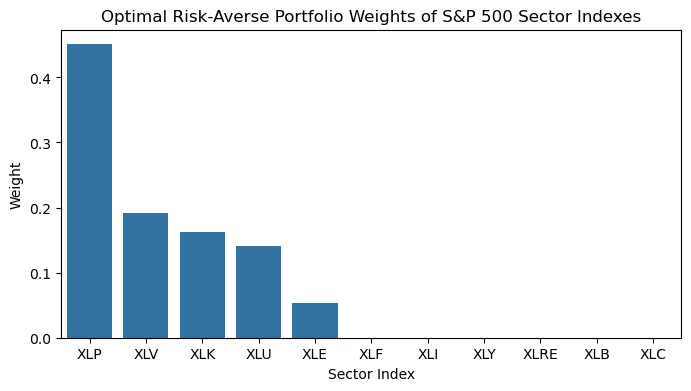

In [104]:
# visualizing the portfolio allocation that minimizes the risk-to-return ratio
min_rr_ratio = df_output['rr_ratio'].min()
optimal_slice = df_output.loc[df_output['rr_ratio'] == min_rr_ratio]
optimal_weights = optimal_slice.iloc[:, 4:].T.sort_values(by = 0, ascending = False)
x_ticks = [weight.split('_')[0] for weight in optimal_weights.index]

print('_' * 50)
print('Risk-to-Return Ratio:', round(min_rr_ratio, 4))
print('Standard Deviation:', round(optimal_slice['std_dev'].values[0], 4))
print('Expected Return:', round(optimal_slice['return'].values[0], 4))
print('_' * 50)

plt.figure(figsize = (8, 4))
sns.barplot(data = optimal_weights, x = x_ticks, y = 0)
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes')
plt.show()

In [98]:
optimal_slice

,return,variance,std_dev,rr_ratio,XLC_weight,XLY_weight,XLP_weight,XLE_weight,XLF_weight,XLV_weight,XLI_weight,XLB_weight,XLRE_weight,XLK_weight,XLU_weight
0,0.135,0.006,0.077,0.573,-0.000,-0.000,0.451,0.054,0.000,0.191,-0.000,-0.000,-0.000,0.163,0.141
